In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from math import sqrt
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from vecstack import stacking

D:\AnacondaNavigator\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_csv(r'C:/Users/Venom/Desktop/694560_1215964_bundle_archive/preprocessed_data.csv')

In [5]:
df.City.unique()

array(['Algiers', 'Bombay (Mumbai)', 'Dallas Ft Worth', 'Lansing',
       'Ankara', 'Grand Rapids', 'Istanbul', 'Abu Dhabi', 'Flint',
       'Dubai', 'Hong Kong', 'El Paso', 'Detroit', 'Calgary', 'Edmonton',
       'Lilongwe', 'Boston', 'Halifax', 'Montreal', 'Grand Junction',
       'Ottawa', 'Shenyang', 'Addis Ababa', 'Milwaukee', 'Baltimore',
       'Quebec', 'Shanghai', 'Houston', 'Sault Ste Marie', 'Roanoke',
       'Riyadh', 'Duluth', 'Great Falls', 'Belfast', 'London', 'Pueblo',
       'Orlando', 'Delhi', 'Banjul', 'Billings', 'Belgrade',
       'Chennai (Madras)', 'Brownsville', 'St Louis', 'Manama',
       'Portland', 'Kansas City', 'Madison', 'Amman', 'Calcutta',
       'Corpus Christi', 'Kuwait', 'Wilmington', 'Tupelo', 'Beirut',
       'Jackson', 'Washington DC', 'Minneapolis St. Paul', 'Doha',
       'Dhahran', 'Tel Aviv', 'Kiev', 'Regina', 'Lusaka', 'San Angelo',
       'Topeka', 'San Jose', 'Goodland', 'Sioux City', 'Guayaquil',
       'Des Moines', 'Quito', 'San Antonio

In [57]:
df.shape

(2758800, 12)

In [58]:
df.columns

Index(['Region', 'Country', 'City', 'Month', 'Day', 'Year', 'AvgTemperature',
       'Latitude', 'Longitude', 'dist_from_north', 'dist_from_south', 'Date'],
      dtype='object')

In [59]:
df.Date.max(),df.Date.min()

('2019-12-31', '1995-01-01')

In [60]:
df.shape

(2758800, 12)

In [61]:
df.dtypes

Region              object
Country             object
City                object
Month                int64
Day                  int64
Year                 int64
AvgTemperature     float64
Latitude           float64
Longitude          float64
dist_from_north    float64
dist_from_south    float64
Date                object
dtype: object

In [62]:
#yyyy-mm-dd

In [63]:
df['Date'] = pd.to_datetime(df['Date'])

In [64]:
df.Date.quantile(0),df.Date.quantile(1)

(Timestamp('1995-01-01 00:00:00'), Timestamp('2019-12-31 00:00:00'))

In [65]:
def train_test_split(data,column,train_start_date, train_end_date,test_start_date,test_end_date):
    train_start_date = pd.to_datetime(train_start_date)
    train_end_date =  pd.to_datetime(train_end_date)
    test_start_date =  pd.to_datetime(test_start_date)
    test_end_date = pd.to_datetime(test_end_date)
    data[column] = pd.to_datetime(data[column])
    train = data.loc[(data[column]>=train_start_date)&(data[column]<=train_end_date)]
    test = data.loc[(data[column]>=test_start_date)&(data[column]<=test_end_date)]
    train.reset_index(drop =True,inplace = True)
    test.reset_index(drop =True,inplace = True)
    return train,test
def get_mape(actual, predicted):
    y_true, y_pred = np.array(actual), np.array(predicted)
    return np.round( np.mean(np.abs((actual - predicted)/ actual)) * 100, 2)

In [66]:
df['prev_day'] = df.groupby('City').AvgTemperature.shift(1)
df['prev_2day'] = df.groupby('City').AvgTemperature.shift(2)
df['prev_3day'] = df.groupby('City').AvgTemperature.shift(3)
df['prev_year'] = df.groupby('City').AvgTemperature.shift(365)
df['prev_2year'] = df.groupby('City').AvgTemperature.shift(365*2)
df['prev_3year'] = df.groupby('City').AvgTemperature.shift(365*3)

In [67]:
df['Season'] = (df.Month%12 + 3)//3

In [68]:
x_train,x_test = train_test_split(df[(df.Region!='North America')].copy(),'Date','1995-01-01','2018-12-30','2018-12-31','2019-12-31')

In [69]:
x_train.shape,x_test.shape

((1203084, 19), (46940, 19))

In [70]:
cat = [i for i in x_train.columns if x_train[i].dtypes=='object']

In [71]:
cat

['Region', 'Country', 'City']

In [72]:
region_temp_mapper = x_train.groupby('Region').AvgTemperature.mean().to_dict()
country_temp_mapper =  x_train.groupby('Country').AvgTemperature.mean().to_dict()
city_temp_mapper =  x_train.groupby('City').AvgTemperature.mean().to_dict()

In [73]:
x_train['Region_enc'] = x_train['Region'].map(region_temp_mapper)
x_test['Region_enc'] = x_test['Region'].map(region_temp_mapper)

x_train['Country_enc'] = x_train['Country'].map(country_temp_mapper)
x_test['Country_enc'] = x_test['Country'].map(country_temp_mapper)

x_train['City_enc'] = x_train['City'].map(city_temp_mapper)
x_test['City_enc'] = x_test['City'].map(city_temp_mapper)

In [74]:
x_train['is_neg_percent'] = np.where(x_train.AvgTemperature<0,1,0)
neg_mapper = x_train.groupby('City').apply(lambda x:x.is_neg_percent.mean()*100).to_dict()
x_train['is_neg_percent'] = x_train['City'].map(neg_mapper)
x_test['is_neg_percent'] = x_test['City'].map(neg_mapper)

In [75]:
x_train['combined'] = x_train.Country.astype(str)+"_"+x_train.Month.astype(str)
country_month_details = x_train.groupby(['combined']).AvgTemperature.mean().to_dict()
x_train['country_month_mean'] = x_train.combined.map(country_month_details)

x_test['combined'] = x_test.Country.astype(str)+"_"+x_test.Month.astype(str)
x_test['country_month_mean'] = x_test.combined.map(country_month_details)


In [76]:
x_train['combined'] = x_train.City.astype(str)+"_"+x_train.Season.astype(str)
city_season_details = x_train.groupby(['combined']).AvgTemperature.mean().to_dict()
x_train['city_season_mean'] = x_train.combined.map(city_season_details)

x_test['combined'] = x_test.City.astype(str)+"_"+x_test.Season.astype(str)
x_test['city_season_mean'] = x_test.combined.map(city_season_details)


In [77]:
x_train['combined'] = x_train.City.astype(str)+"_"+x_train.Month.astype(str)
city_month_details = x_train.groupby(['combined']).AvgTemperature.mean().to_dict()
x_train['city_month_mean'] = x_train.combined.map(city_month_details)

x_test['combined'] = x_test.City.astype(str)+"_"+x_test.Month.astype(str)
x_test['city_month_mean'] = x_test.combined.map(city_month_details)


In [78]:
x_train.drop('combined',inplace=True,axis = 1)
x_test.drop('combined',inplace=True,axis = 1)

In [79]:
x_train['days_rolling_mean'] = x_train.groupby('City')['AvgTemperature'].rolling(30).mean().reset_index(0,drop=True)
rolling_mean_mapper = x_train.groupby('City').days_rolling_mean.mean().to_dict()
x_test['days_rolling_mean'] = x_test['City'].map(rolling_mean_mapper)

In [80]:
x_train['years_rolling_mean'] = x_train.groupby('City')['AvgTemperature'].rolling(365).mean().reset_index(0,drop=True)
rolling_mean_mapper = x_train.groupby('City').years_rolling_mean.mean().to_dict()
x_test['years_rolling_mean'] = x_test['City'].map(rolling_mean_mapper)

In [81]:
y_train = x_train.AvgTemperature
y_test = x_test.AvgTemperature

In [82]:
x_train.columns

Index(['Region', 'Country', 'City', 'Month', 'Day', 'Year', 'AvgTemperature',
       'Latitude', 'Longitude', 'dist_from_north', 'dist_from_south', 'Date',
       'prev_day', 'prev_2day', 'prev_3day', 'prev_year', 'prev_2year',
       'prev_3year', 'Season', 'Region_enc', 'Country_enc', 'City_enc',
       'is_neg_percent', 'country_month_mean', 'city_season_mean',
       'city_month_mean', 'days_rolling_mean', 'years_rolling_mean'],
      dtype='object')

In [83]:
selected = ['Month', 'Longitude', 'dist_from_north', 'prev_year','prev_2year','prev_3year','city_month_mean',
            'days_rolling_mean','years_rolling_mean','is_neg_percent','city_season_mean']
len(selected)

11

In [84]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((1203084, 28), (46940, 28), (1203084,), (46940,))

In [85]:
x_train.Date.max()-x_train.Date.min(),x_test.Date.max()-x_test.Date.min()

(Timedelta('8764 days 00:00:00'), Timedelta('365 days 00:00:00'))

In [86]:
x_train.columns

Index(['Region', 'Country', 'City', 'Month', 'Day', 'Year', 'AvgTemperature',
       'Latitude', 'Longitude', 'dist_from_north', 'dist_from_south', 'Date',
       'prev_day', 'prev_2day', 'prev_3day', 'prev_year', 'prev_2year',
       'prev_3year', 'Season', 'Region_enc', 'Country_enc', 'City_enc',
       'is_neg_percent', 'country_month_mean', 'city_season_mean',
       'city_month_mean', 'days_rolling_mean', 'years_rolling_mean'],
      dtype='object')

In [87]:
model = lgb.LGBMRegressor(n_estimators=500, max_depth=5,learning_rate=0.01)
x_train['weights'] = np.where(x_train.AvgTemperature<20,3,1)
model.fit(x_train[selected].fillna(0,axis = 1),y_train,x_train['weights'] )

LGBMRegressor(learning_rate=0.01, max_depth=5, n_estimators=500)

In [88]:
x_test[selected].head()

,Month,Longitude,dist_from_north,prev_year,prev_2year,prev_3year,city_month_mean,days_rolling_mean,years_rolling_mean,is_neg_percent,city_season_mean
0,12,4.893604,3959.389720,42.4,47.1,54.1,39.996341,51.340468,51.283330,0.0,39.381548
1,12,20.456897,4506.544155,51.5,42.2,42.8,35.775610,54.600701,54.526288,0.0,35.641261
2,12,120.979970,7661.527456,80.8,79.6,81.0,80.274898,82.304893,82.317638,0.0,80.044357
3,12,72.835335,6866.138885,78.7,79.9,77.8,78.898236,82.096788,82.078040,0.0,77.841744
4,12,58.387426,4808.604191,46.3,44.6,46.9,40.889946,63.952143,63.873988,0.0,40.413735


In [89]:
x_train.weights.value_counts()

1    1188228
3      14856
Name: weights, dtype: int64

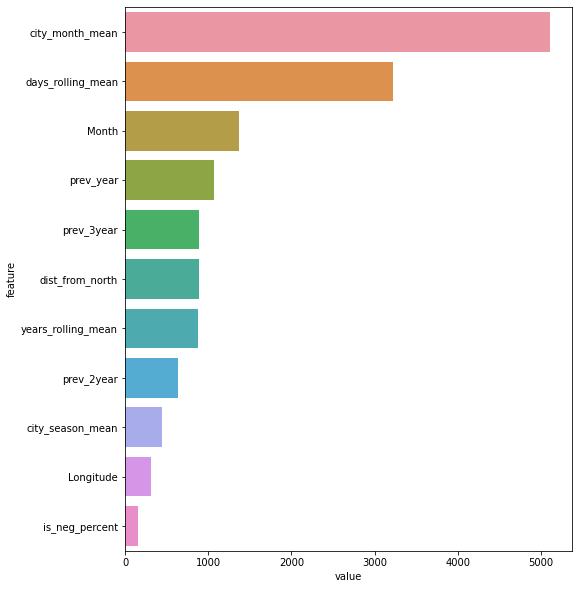

In [90]:
feat_importance = pd.DataFrame()
feat_importance["feature"] = selected
feat_importance["value"] = model.feature_importances_
feat_importance.sort_values(by='value', ascending=False, inplace=True)

plt.figure(figsize=(8,10))
ax = sns.barplot(y="feature", x="value", data=feat_importance)

In [91]:
pred = model.predict(x_test[selected])

In [92]:
rmse = sqrt(mean_squared_error(y_test, pred))
print("RMSE : ",rmse)

RMSE :  4.9092547333799335


In [93]:
print("MAE : ",mean_absolute_error(y_test, pred))

MAE :  3.604582587351055


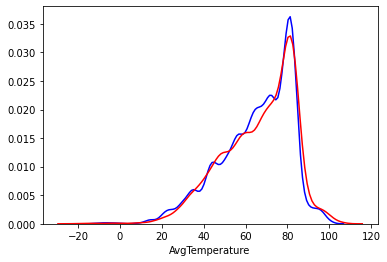

In [94]:
sns.distplot(pred, hist=False,color='b')
sns.distplot(y_test, hist=False,color='r')

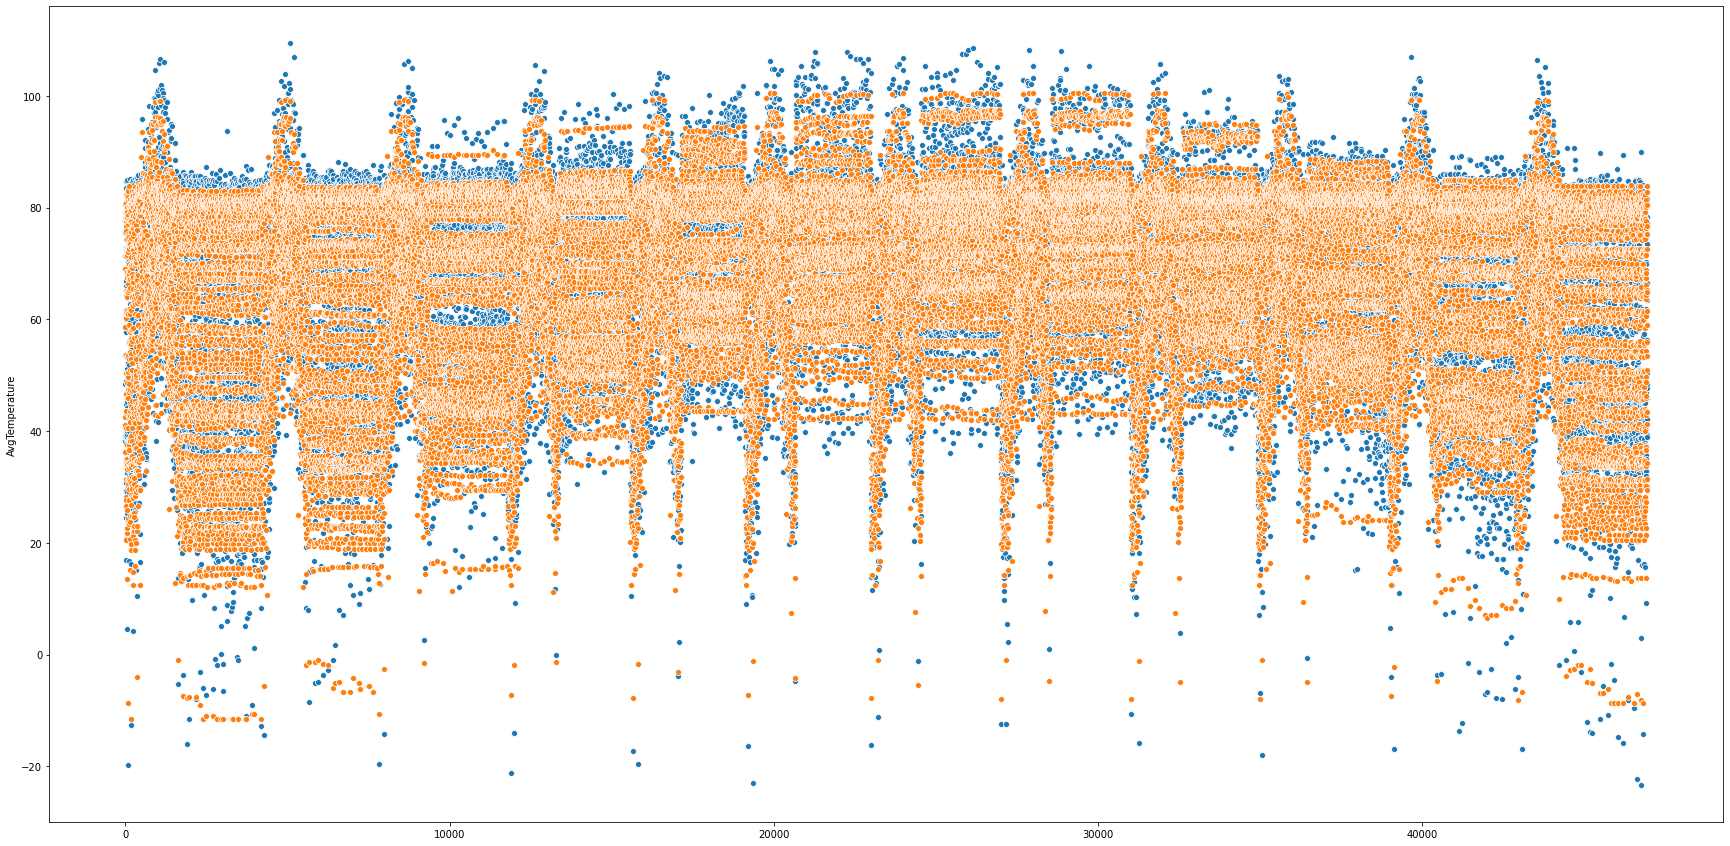

In [95]:
plt.figure(figsize=(30,15))
sns.scatterplot(np.arange(y_test.shape[0]),y_test)
sns.scatterplot(np.arange(y_test.shape[0]),pred)

In [96]:
result = pd.DataFrame()
result = x_test
result['actual'] = y_test
result['predicted'] = pred

In [97]:
result['error'] = np.abs(result.actual-result.predicted)

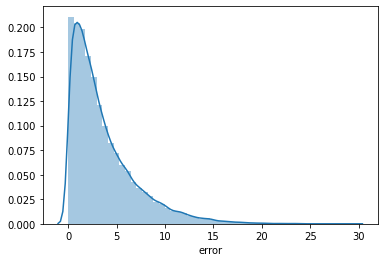

In [98]:
sns.distplot(result.error)

In [99]:
print("SPOT ON % : ",result[result.predicted.astype(int)==result.actual.astype(int)].shape[0]/result.shape[0]*100)
print("+-3 % : ",result[result.error<=3].shape[0]/result.shape[0]*100)
print("+-5 % : ",result[result.error<=5].shape[0]/result.shape[0]*100)
print("+-7 % : ",result[result.error<=7].shape[0]/result.shape[0]*100)
print("+-10 % : ",result[result.error<=10].shape[0]/result.shape[0]*100)

SPOT ON % :  10.419684703877289
+-3 % :  55.66893907115467
+-5 % :  74.92543672773753
+-7 % :  85.90115040477205
+-10 % :  94.30549637835534


In [100]:
result[result.predicted==result.predicted.min()]['Date']

2404   2019-01-18
Name: Date, dtype: datetime64[ns]

In [101]:
x_train[selected].dtypes

Month                   int64
Longitude             float64
dist_from_north       float64
prev_year             float64
prev_2year            float64
prev_3year            float64
city_month_mean       float64
days_rolling_mean     float64
years_rolling_mean    float64
is_neg_percent        float64
city_season_mean      float64
dtype: object

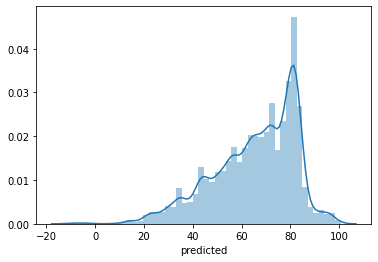

In [102]:
sns.distplot(result.predicted)

In [103]:
result[result.predicted<20]

,Region,Country,City,Month,Day,Year,AvgTemperature,Latitude,Longitude,dist_from_north,...,City_enc,is_neg_percent,country_month_mean,city_season_mean,city_month_mean,days_rolling_mean,years_rolling_mean,actual,predicted,error
60,Asia,China,Shenyang,12,31,2018,4.6,41.804109,123.427636,4700.623133,...,47.652142,1.374256,39.637652,16.298376,16.988211,47.716596,47.647186,4.6,13.601007,9.001007
71,Asia,Mongolia,Ulan-bator,12,31,2018,-19.8,47.918468,106.917702,3816.134633,...,30.497204,21.063488,-6.938587,-7.069081,-6.938587,30.579161,30.462407,-19.8,-8.699756,11.100244
159,Europe,Russia,Moscow,1,1,2019,24.3,55.750446,37.617494,3058.854879,...,42.372303,1.395721,21.306575,20.245758,18.492318,42.422457,42.318570,24.3,15.082002,9.217998
173,Asia,Japan,Sapporo,1,1,2019,23.8,43.061936,141.354292,4853.589376,...,45.039712,0.011438,35.171608,22.875626,20.498383,45.083876,45.018680,23.8,19.773706,4.026294
174,Asia,Mongolia,Ulan-bator,1,1,2019,-12.6,47.918468,106.917702,3816.134633,...,30.497204,21.063488,-11.864777,-7.069081,-11.864777,30.579161,30.462407,-12.6,-11.485086,1.114914
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46654,Asia,China,Shenyang,12,29,2019,16.9,41.804109,123.427636,4700.623133,...,47.652142,1.374256,39.637652,16.298376,16.988211,47.716596,47.647186,16.9,13.630641,3.269359
46746,Asia,Mongolia,Ulan-bator,12,30,2019,-23.3,47.918468,106.917702,3816.134633,...,30.497204,21.063488,-6.938587,-7.069081,-6.938587,30.579161,30.462407,-23.3,-8.211991,15.088009
46761,Asia,China,Shenyang,12,30,2019,2.9,41.804109,123.427636,4700.623133,...,47.652142,1.374256,39.637652,16.298376,16.988211,47.716596,47.647186,2.9,13.630641,10.730641
46819,Asia,Mongolia,Ulan-bator,12,31,2019,-14.3,47.918468,106.917702,3816.134633,...,30.497204,21.063488,-6.938587,-7.069081,-6.938587,30.579161,30.462407,-14.3,-8.699756,5.600244


In [105]:
import joblib

In [106]:
joblib.dump(model,"model.pkl")

['model.pkl']